In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Input, Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from tensorflow.keras import losses

from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator

%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

"""
(noticed: the following codes activate only when using GPU to run the model, 
 but I'm not using GPU support I think. )

# check to be sure that TensorFlow is able to identify the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
# set_memory_growth() allocate only as much GPU memory as needed at a given time, 
# and continues to allocate more when needed
tf.config.experimental.set_memory_growth(physical_devices[0], True)

(IndexError                                Traceback (most recent call last)
<ipython-input-3-df3199446273> in <module>
     37 # set_memory_growth() allocate only as much GPU memory as needed at a given time,
     38 # and continues to allocate more when needed
---> 39 tf.config.experimental.set_memory_growth(physical_devices[0], True)

IndexError: list index out of range)
"""


Using TensorFlow backend.


'\n(noticed: the following codes activate only when using GPU to run the model, \n but I\'m not using GPU support I think. )\n\n# check to be sure that TensorFlow is able to identify the GPU\nphysical_devices = tf.config.experimental.list_physical_devices(\'GPU\')\nprint("Num GPUs Available: ", len(physical_devices))\n# set_memory_growth() allocate only as much GPU memory as needed at a given time, \n# and continues to allocate more when needed\ntf.config.experimental.set_memory_growth(physical_devices[0], True)\n\n(IndexError                                Traceback (most recent call last)\n<ipython-input-3-df3199446273> in <module>\n     37 # set_memory_growth() allocate only as much GPU memory as needed at a given time,\n     38 # and continues to allocate more when needed\n---> 39 tf.config.experimental.set_memory_growth(physical_devices[0], True)\n\nIndexError: list index out of range)\n'

In [2]:
# I. data preparation
# organize the kaggle dogs vs cats train data into train, validation, and test directories

# SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: 
# truncated \UXXXXXXXX escape(change "\" into "/" in the file path)
os.chdir('D:/computer science lab/dogs_vs_cats')
if os.path.isdir('train/dog') is False:
    os.makedirs('train/dog')
    os.makedirs('train/cat')
    os.makedirs('valid/dog')
    os.makedirs('valid/cat')
    os.makedirs('test/dog')
    os.makedirs('test/cat')

    for i in random.sample(glob.glob('cat*'), 500):
        shutil.move(i, 'train/cat')      
    for i in random.sample(glob.glob('dog*'), 500):
        shutil.move(i, 'train/dog')
    for i in random.sample(glob.glob('cat*'), 100):
        shutil.move(i, 'valid/cat')        
    for i in random.sample(glob.glob('dog*'), 100):
        shutil.move(i, 'valid/dog')
    for i in random.sample(glob.glob('cat*'), 50):
        shutil.move(i, 'test/cat')      
    for i in random.sample(glob.glob('dog*'), 50):
        shutil.move(i, 'test/dog')

os.chdir('../../')


In [3]:
# assign the path to path variables for upcoming preprocessing
train_path = 'D:/computer science lab/dogs_vs_cats/train'
valid_path = 'D:/computer science lab/dogs_vs_cats/valid'
test_path = 'D:/computer science lab/dogs_vs_cats/test'


In [4]:
# use Keras' ImageDataGenerator class to create batches of data from the train, valid, and test directories.
train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=['cat', 'dog'], batch_size=10, shuffle=False)


Found 1000 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 100 images belonging to 2 classes.


In [5]:
# verify the number of images and classes are correct
assert train_batches.n == 1000
assert valid_batches.n == 200
assert test_batches.n == 100
# Fix for Keras 2.1: num_class is now num_classes for DirectoryIterator
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

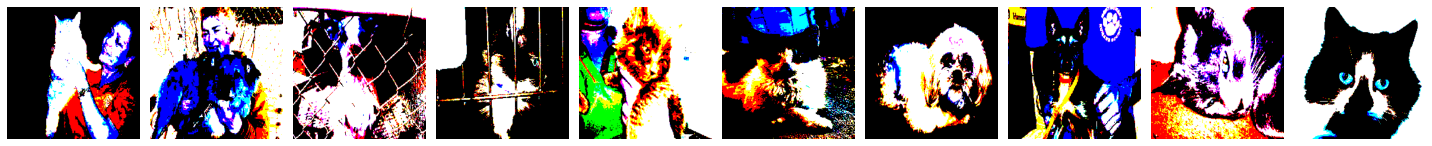

[[1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]]


In [6]:
imgs, labels = next(train_batches)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)


In [8]:
"""
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding = 'same', input_shape=(224,224,3)),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding = 'same'),
    MaxPool2D(pool_size=(2, 2), strides=2),
    Flatten(),
    Dense(units=2, activation='softmax')
])
"""
# Alexnet
model = Sequential()
model.add(Conv2D(96,(11,11),strides=(4,4),input_shape=(224,224,3),padding='valid',activation='relu',kernel_initializer='uniform'))  
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
model.add(Conv2D(256,(5,5),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model.add(Conv2D(384,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model.add(Conv2D(256,(3,3),strides=(1,1),padding='same',activation='relu',kernel_initializer='uniform'))  
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))  
model.add(Flatten())  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(4096,activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(1000,activation='relu'))  
model.add(Dropout(0.5))
model.add(Dense(units=2, activation='softmax'))

In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 12, 12, 256)      

In [10]:
model.compile(optimizer=Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
model.fit(x=train_batches,
    steps_per_epoch=len(train_batches),
    validation_data=valid_batches,
    validation_steps=len(valid_batches),
    epochs=10,
    verbose = 2
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 100 steps, validate for 20 steps
Epoch 1/10
100/100 - 93s - loss: 0.6804 - accuracy: 0.6040 - val_loss: 0.6492 - val_accuracy: 0.6100
Epoch 2/10
100/100 - 94s - loss: 0.5936 - accuracy: 0.6610 - val_loss: 0.7236 - val_accuracy: 0.5800
Epoch 3/10
100/100 - 94s - loss: 0.5622 - accuracy: 0.7130 - val_loss: 0.6725 - val_accuracy: 0.6250
Epoch 4/10
100/100 - 91s - loss: 0.5423 - accuracy: 0.7240 - val_loss: 0.7343 - val_accuracy: 0.5850
Epoch 5/10
100/100 - 94s - loss: 0.5513 - accuracy: 0.7320 - val_loss: 0.6926 - val_accuracy: 0.6200
Epoch 6/10
100/100 - 94s - loss: 0.5956 - accuracy: 0.7080 - val_loss: 0.6348 - val_accuracy: 0.6450
Epoch 7/10
100/100 - 107s - loss: 0.4227 - accuracy: 0.8040 - val_loss: 0.6238 - val_accuracy: 0.6700
Epoch 8/10
100/100 - 104s - loss: 0.3889 - accuracy: 0.8210 - val_loss: 0.7403 - val_accuracy: 0.6150
Epoch 9/10
100/100 - 98s - loss: 0.3387 - accuracy: 0.8490 - val_loss: 0.7292 - val_accuracy: 0.6

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

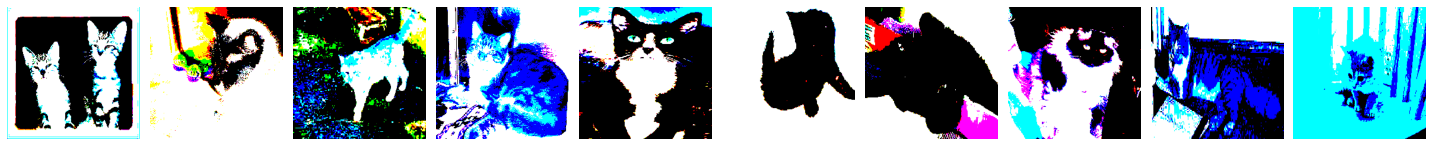

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [13]:
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
print(test_labels)

In [14]:
test_batches.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [15]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [16]:
np.round(predictions)

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.

In [17]:
cm = confusion_matrix(y_true=test_batches.classes, y_pred=np.argmax(predictions, axis=-1))

In [18]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [19]:
test_batches.class_indices

{'cat': 0, 'dog': 1}

Confusion matrix, without normalization
[[28 22]
 [20 30]]


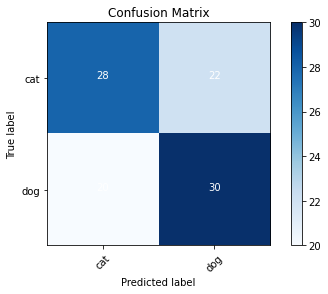

In [20]:
cm_plot_labels = ['cat','dog']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')